![example](images/director_shot.jpeg)

# Microsoft Studios Film Profit Analysis

**Author:** Morgan Didjurgis
***

## Overview

This project's purpose is to provide recommendations on what type of films perform the best for Microsoft, since they are opening a new movie studio. Analysis of almost 2000 movies made in the US in the last 10 years shows that higher budget films (over $40 million) tend to have higher profits. Among higher budget films, those with certain genres, MPAA ratings, and release months tend to perform better on average. 

## Business Problem

Microsoft is seeking recommendations for which type of films they can make in order to have the best chance at maximizing profit. While films are generally risky business ventures, this risk can be reduced by choosing budget sizes, genres, MPAA ratings, and release months that have been shown to have higher success rates. 

This project will evaluate:

1) Is budget size correlated with profit?

2) Which genres tend to perform the best?

3) Which MPAA ratings tend to perform the best? I'll also examine which MPAA ratings perform the best within the most profitable genres, since this can be very specific to the type of movie.

4) Do certain release months tend to have higher profits? Does this vary by genre?


## Data Understanding

The data for this project came from multiple online movie databases.  The primary source was the IMDB (Internet Movie Database) API with some additional data gathered from Box Office Mojo and TMDB (The Movie Database).

The main variables I intend to use for analysis are worldwide gross, budget, MPAA rating, genre, and release month. Worldwide gross and budget will be used to calculate profit. Budget, MPAA rating, genre, and release month will be used to determine which film characteristics tend to lead to higher profit. MPAA rating, genre, and release month are all categorical, which I will have to keep in mind during the analysis.

The code for data collection and filtering is contained in 'api_calls.ipynb'. Below is a summary of my process and major decision points.

1) I started with a list of over 146,000 movies with basic information including IMDB id, title, start year, runtime, and genre. From this list, I filtered out any movies made after 2020 since there were a number of upcoming releases listed.

2) I used the IMDB ids to query the IMDB API versions endpoint and get country data for these movies. I only kept movies made in the US, since Microsoft is a US based company. I had 49,608 movies after filtering for country of origin.

3) I then queried the IMDB business endpoint to get worldwide gross and budget data for as many US movies as possible.

4) Next, I merged the IMDB dataset with data from Box Office Mojo using original titles and filled in budget, domestic gross, and worldwide gross data that was not available on IMDB that this dataset contained.

5) Using domestic gross and international gross, I was able to estimate worldwide gross for a few movies where that information was not provided directly.

6) Before making any further queries for other movie information, I filtered the dataset, removing any films without worldwide gross, since this information is crucial to the analysis.  I also only included films with a runtime between 45 minutes and 4 hours, since anything outside this range would not be the type of movie I am making recommendations to Microsoft about. After this, I had 4065 movies remaining.

7) I then queried the IMDB overview endpoint to get MPAA rating and Release Date data. I extracted the month from the release date since I am mostly interested in what month the movie was released.

8) Lastly, I queried TMDB to find additional information on budget, relase date and MPAA rating for  movies missing those values. To do this I isolated films missing any of these values, queried TMDB using the IMDB id to find the matching TMDB id, then queried the TMDB details and release date endpoints.

9) The data resulting from this process is saved under 'imdb_all_data.csv'

In [110]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.float_format', lambda x: f'{x: ,.2f}')

# Approach #

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
First, I will standardize the formats for all of the variables, since they were collected from three different databases. 

Genres: I converted the strings containing multiple genres into Python lists so that they could later be exploded for easier analysis of genres.

MPAA Rating: I examined all the values in this column and found that a number of the ratings were actually meant for television. Many of these films still had theatrical releases and financial data, so I decided to convert TV ratings to their MPAA equivalent. The maturity content of the film is the most important piece of information from this variable and TV ratings were still a good estimate for this.

Month: I had already pulled release month out of the various release date formats, so these did not have to be cleaned any further.
***

Since I will mainly be using profit to analyze how sucessful a film was, I decided to drop all rows that did not have budget information. While this meant dropping a large portion of the data, I still had approximately 2000 films and it would allow me to provide better recommendations to Microsoft. Using only worldwide gross could be misleading since high grossing films can have extremely large budgets and low grossing films may have extremely small budgets that still make them fairly profitable.

I also investigated rows with missing genres, MPAA ratings, and months.  I found that many of the rows missing this data were actually duplicates that I had not previously identified due to slightly different title information and different IMDB ids. These duplicates had other entries with all the data available, so I decided to drop the rows with missing data.



In [3]:
movies=pd.read_csv('imdb_all_data.csv')
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4065 entries, 0 to 4064
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       4065 non-null   int64  
 1   tconst           4065 non-null   object 
 2   original_title   4065 non-null   object 
 3   start_year       4065 non-null   int64  
 4   runtime_minutes  4065 non-null   float64
 5   genres           4063 non-null   object 
 6   budget           2025 non-null   object 
 7   ww_gross         4065 non-null   float64
 8   mpaa_rating      3700 non-null   object 
 9   month            4032 non-null   float64
dtypes: float64(3), int64(2), object(5)
memory usage: 317.7+ KB


### genres ###

Check for any variable formatting. Split genres into list of strings. For analysis, I will explode the list of genres.

In [4]:
movies['genres'].str.split(',').explode().value_counts()

Drama                  1818
Comedy                 1131
Documentary             886
Thriller                600
Action                  598
Horror                  476
Crime                   457
Romance                 450
Adventure               439
Biography               375
Mystery                 272
Sci-Fi                  201
Family                  193
Fantasy                 187
History                 179
Music                   177
Animation               154
Sport                    98
War                      36
Western                  36
News                     33
Musical                  30
['Documentary']           3
['Science Fiction']       1
Name: genres, dtype: int64

In [5]:
#fix ['Documentary'] and ['Science Fiction']

movies[(movies['genres']=="['Documentary']") | 
       (movies['genres']=="['Science Fiction']")]

,Unnamed: 0,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
670,670,tt1482889,Jim,2010,101.0,['Science Fiction'],NaN,13000.0,Unrated,10.0
3371,3371,tt5515304,Frey: Part I - The Architectural Envoy,2018,65.0,['Documentary'],NaN,2248.0,NaN,2.0
3893,3893,tt7689908,Crime + Punishment,2018,112.0,['Documentary'],NaN,18644.0,NaN,8.0
3894,3894,tt7689956,Chef Flynn,2018,82.0,['Documentary'],NaN,69542.0,NaN,11.0


In [6]:
#correct these rows
movies.loc[670,'genres']='Sci-Fi'
movies.loc[[3371,3893,3894],'genres']='Documentary'

In [7]:
movies['genres'].str.split(',').explode().value_counts()

Drama          1818
Comedy         1131
Documentary     889
Thriller        600
Action          598
Horror          476
Crime           457
Romance         450
Adventure       439
Biography       375
Mystery         272
Sci-Fi          202
Family          193
Fantasy         187
History         179
Music           177
Animation       154
Sport            98
War              36
Western          36
News             33
Musical          30
Name: genres, dtype: int64

In [8]:
#turn genres into list of strings now that formatting is corrected
movies['genres']=movies['genres'].str.split(',')
movies['genres'].head()

0       [Action, Animation, Comedy]
1        [Drama, Mystery, Thriller]
2    [Adventure, Animation, Comedy]
3        [Adventure, Comedy, Drama]
4            [Action, Crime, Drama]
Name: genres, dtype: object

### ratings ###
Check for any formatting issues

In [9]:
movies['mpaa_rating'].value_counts()

R            1360
PG-13         850
Not Rated     802
PG            358
Unrated       110
TV-MA          74
G              38
TV-14          37
NR             36
TV-PG          23
TV-G            7
TV-Y            3
Approved        1
NC-17           1
Name: mpaa_rating, dtype: int64

1) 'Not Rated' and 'Unrated' are the same, so I will change these all to 'Unrated'. <br>
2) I will explore what 'Approved' means. <br>
3) Explore movies with TV ratings. This analysis is meant for theatrical releases, so movies that were made for TV should not be included. <br>
4) Investigate whether NC-17 movie should be in dataset

In [10]:
#Replace 'Not Rated' with 'Unrated'
movies['mpaa_rating']=movies['mpaa_rating'].\
                    where(movies['mpaa_rating']!='Not Rated',other='Unrated')
movies['mpaa_rating'].value_counts()

R           1360
Unrated      912
PG-13        850
PG           358
TV-MA         74
G             38
TV-14         37
NR            36
TV-PG         23
TV-G           7
TV-Y           3
Approved       1
NC-17          1
Name: mpaa_rating, dtype: int64

In [11]:
movies['mpaa_rating']=movies['mpaa_rating'].\
                    where(movies['mpaa_rating']!='NR',other='Unrated')

In [12]:
#Investigate 'Approved'
movies[movies['mpaa_rating']=='Approved']

,Unnamed: 0,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
3999,3999,tt8803596,Have It All -The Movie,2018,90.0,[Documentary],"{'amount': 250000.0, 'currency': 'USD'}",197142.0,Approved,8.0


From filmratings.com/History, films used to be either Approved/Disapproved based on whether they were moral or unmoral under the Hays Code. The current MPAA rating system replaced this in 1968. It does not make sense that a film from 2018 would be rated Approved, so I will change this value to Unrated.

In [13]:
#Change value to unrated
movies.loc[3999,'mpaa_rating']='Unrated'

In [14]:
#Explore movies that are TV-PG
movies[movies['mpaa_rating']=='TV-PG']

,Unnamed: 0,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
672,672,tt1482991,Carbon Nation,2010,86.0,"[Documentary, Family]",NaN,16901.0,TV-PG,10.0
1420,1420,tt1930322,Destiny Road,2012,100.0,[Drama],NaN,926114.0,TV-PG,4.0
1577,1577,tt2040398,La Camioneta: The Journey of One American Scho...,2012,71.0,[Documentary],NaN,18558.0,TV-PG,3.0
1795,1795,tt2222206,Dear Mr. Watterson,2013,89.0,[Documentary],NaN,23899.0,TV-PG,4.0
2020,2020,tt2402114,Forgive - Don't Forget,2018,69.0,"[Documentary, History, War]",NaN,128000.0,TV-PG,7.0
2139,2139,tt2545088,American Promise,2013,135.0,[Documentary],NaN,146702.0,TV-PG,1.0
2206,2206,tt2660118,Split,2016,90.0,"[Comedy, Romance, Sport]",NaN,278500000.0,TV-PG,8.0
2557,2557,tt3379352,Mully,2015,81.0,"[Adventure, Biography, Documentary]",NaN,1489771.0,TV-PG,10.0
2698,2698,tt3676370,Breaking Through,2015,101.0,"[Drama, Music]",NaN,617208.0,TV-PG,10.0
3004,3004,tt4425148,Life in a Walk,2015,76.0,"[Adventure, Documentary, Family]",NaN,16557.0,TV-PG,12.0


From digging into the movies on the list, it is clear that many of these movies had theatrical releases. The majority of the movies that I checked have TV ratings that coincide with their MPAA ratings, so I will replace the TV ratings with MPAA ratings, so that they are grouped generally in the correct category for maturity of the content.

In [15]:
#Change TV ratings to their MPAA equivalent
new_ratings={'TV-Y':'G','TV-G':'G','TV-PG':'PG','TV-14':'PG-13','TV-MA':'R'}
movies['mpaa_rating']=movies['mpaa_rating'].apply(lambda x:
                                                 new_ratings[x] if x in 
                                                 new_ratings else x)
movies['mpaa_rating'].value_counts()

R          1434
Unrated     949
PG-13       887
PG          381
G            48
NC-17         1
Name: mpaa_rating, dtype: int64

In [16]:
movies[movies['mpaa_rating']=='NC-17']

,Unnamed: 0,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
3919,3919,tt7947150,This One's for the Ladies,2018,82.0,[Documentary],NaN,13688.0,NC-17,5.0


In [17]:
#remove this movie- not the kind of material discussed in analysis and didn't
#make much money
movies=movies[movies['mpaa_rating']!='NC-17']
movies['mpaa_rating'].value_counts()

R          1434
Unrated     949
PG-13       887
PG          381
G            48
Name: mpaa_rating, dtype: int64

In [18]:
movies.drop(['Unnamed: 0'],axis=1,inplace=True)
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4064 entries, 0 to 4064
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           4064 non-null   object 
 1   original_title   4064 non-null   object 
 2   start_year       4064 non-null   int64  
 3   runtime_minutes  4064 non-null   float64
 4   genres           4062 non-null   object 
 5   budget           2025 non-null   object 
 6   ww_gross         4064 non-null   float64
 7   mpaa_rating      3699 non-null   object 
 8   month            4031 non-null   float64
dtypes: float64(3), int64(1), object(5)
memory usage: 317.5+ KB


In [19]:
movies.to_csv('29SEP_movies.csv')

In [20]:
movies=pd.read_csv('29SEP_movies.csv')
movies.drop(['Unnamed: 0'],axis=1,inplace=True)
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4064 entries, 0 to 4063
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           4064 non-null   object 
 1   original_title   4064 non-null   object 
 2   start_year       4064 non-null   int64  
 3   runtime_minutes  4064 non-null   float64
 4   genres           4062 non-null   object 
 5   budget           2025 non-null   object 
 6   ww_gross         4064 non-null   float64
 7   mpaa_rating      3699 non-null   object 
 8   month            4031 non-null   float64
dtypes: float64(3), int64(1), object(5)
memory usage: 285.9+ KB


### month ###
Look at distribution of month data and determine how to handle missing values

<AxesSubplot:ylabel='Frequency'>

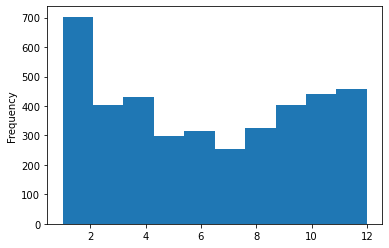

In [21]:
movies['month'].plot(kind='hist')

I could fill in the missing month data by using random months with the same distribution as the data, but I don't think this would add to the analysis, since there are only 33/4064 missing values. I will consider dropping these rows after I finish looking at other missing values.

### budget ###

Get all budget data in same format as type float

In [23]:
movies[movies['budget'].apply(lambda x: type(x))==str].head(50)


,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
0,tt0249516,Foodfight!,2012,91.00,"['Action', 'Animation', 'Comedy']","{'amount': 65000000.0, 'currency': 'USD'}","120,141.00",PG,2.00
1,tt0326965,In My Sleep,2010,104.00,"['Drama', 'Mystery', 'Thriller']","{'amount': 1000000.0, 'currency': 'USD'}","30,158.00",PG-13,4.00
3,tt0359950,The Secret Life of Walter Mitty,2013,114.00,"['Adventure', 'Comedy', 'Drama']","{'amount': 90000000, 'currency': 'USD'}","188,133,322.00",PG,12.00
4,tt0365907,A Walk Among the Tombstones,2014,114.00,"['Action', 'Crime', 'Drama']","{'amount': 28000000, 'currency': 'USD'}","58,834,384.00",R,9.00
5,tt0369610,Jurassic World,2015,124.00,"['Action', 'Adventure', 'Sci-Fi']","{'amount': 150000000, 'currency': 'USD'}","1,670,516,444.00",PG-13,6.00
6,tt0372538,Spy,2011,110.00,"['Action', 'Crime', 'Drama']","{'amount': 5000000.0, 'currency': 'USD'}","235,600,000.00",Unrated,8.00
7,tt0376136,The Rum Diary,2011,119.00,"['Comedy', 'Drama']","{'amount': 45000000, 'currency': 'USD'}","30,134,958.00",R,10.00
8,tt0383010,The Three Stooges,2012,92.00,"['Comedy', 'Family']","{'amount': 30000000, 'currency': 'USD'}","54,819,301.00",PG,4.00
9,tt0398286,Tangled,2010,100.00,"['Adventure', 'Animation', 'Comedy']","{'amount': 260000000, 'currency': 'USD'}","592,462,816.00",PG,11.00
10,tt0401729,John Carter,2012,132.00,"['Action', 'Adventure', 'Sci-Fi']","{'amount': 250000000, 'currency': 'USD'}","284,139,100.00",PG-13,3.00


In [24]:
def find_dicts(data):
    if type(data)==str:
        if '{' in data:
            return True
        else:
            return False
    else:
        return False

type_bool=movies['budget'].apply(find_dicts)

In [25]:
def fix_budget(x):
    data=eval(x)
    return data['amount']

movies.loc[type_bool,'budget']=movies.loc[type_bool,
                                          'budget'].apply(fix_budget)
movies['budget'].head(10)

0     65,000,000.00
1      1,000,000.00
2               NaN
3     90,000,000.00
4     28,000,000.00
5    150,000,000.00
6      5,000,000.00
7     45,000,000.00
8     30,000,000.00
9    260,000,000.00
Name: budget, dtype: object

In [26]:
movies['budget']=movies['budget'].astype(float)

In [27]:
movies['budget'].describe()

count          2,025.00
mean      32,090,687.79
std       49,186,123.98
min                0.00
25%        2,000,000.00
50%       12,000,000.00
75%       36,000,000.00
max      356,000,000.00
Name: budget, dtype: float64

In [28]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4064 entries, 0 to 4063
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           4064 non-null   object 
 1   original_title   4064 non-null   object 
 2   start_year       4064 non-null   int64  
 3   runtime_minutes  4064 non-null   float64
 4   genres           4062 non-null   object 
 5   budget           2025 non-null   float64
 6   ww_gross         4064 non-null   float64
 7   mpaa_rating      3699 non-null   object 
 8   month            4031 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 285.9+ KB


In [29]:
movies.to_csv('30SEP_movies.csv',index=False)

In [30]:
movies=pd.read_csv('30SEP_movies.csv')

### Investigate missing data ###
For genres, mpaa_rating, month, verify whether there are movies with missing data that we want included in the analysis. Check what the highest values for ww_gross for the movies missing these values.

In [31]:
#genres
movies[movies['genres'].isnull()].sort_values('ww_gross',ascending=False)

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
2105,tt2504610,The Oscar Nominated Short Films 2010: Live Action,2010,97.00,NaN,nan,"1,018,169.00",NaN,3.00
1082,tt1701997,I'm Still Here,2010,60.00,NaN,nan,"569,000.00",NaN,nan


In [32]:
#mpaa_rating
missing_rating=movies[movies['mpaa_rating'].isnull()].sort_values('ww_gross',
                                                   ascending=False)

In [35]:
missing_rating.head()

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
1623,tt2071483,Inside Out,2011,59.00,['Family'],"500,000.00","857,600,000.00",NaN,12.00
2847,tt4028068,Wonder Woman,2014,60.00,['Sci-Fi'],"15,000.00","821,900,000.00",NaN,12.00
2526,tt3300078,The Revenant,2012,80.00,['Horror'],"2,000.00","532,900,000.00",NaN,2.00
3456,tt5734820,Rio,2017,87.00,['Drama'],nan,"484,600,000.00",NaN,nan
2185,tt2614250,Rio,2012,90.00,['Documentary'],"250,000.00","484,600,000.00",NaN,nan


In [36]:
movies[movies['original_title'].str.contains('Reven')]

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
404,tt1287468,Cats & Dogs: The Revenge of Kitty Galore,2010,82.00,"['Action', 'Comedy', 'Family']","85,000,000.00","112,483,764.00",PG,7.00
467,tt1322362,Revenge of the Mekons,2013,95.00,['Documentary'],"300,000.00","11,861.00",Unrated,11.00
584,tt1413496,Revenge of the Electric Car,2011,90.00,['Documentary'],nan,"151,272.00",PG-13,4.00
1015,tt1663202,The Revenant,2015,156.00,"['Action', 'Adventure', 'Biography']","135,000,000.00","532,950,503.00",R,1.00
2526,tt3300078,The Revenant,2012,80.00,['Horror'],"2,000.00","532,900,000.00",NaN,2.00


In [37]:
movies[movies['original_title'].str.contains('Inside Out')]

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
962,tt1640486,Inside Out,2011,93.00,"['Crime', 'Drama']","2,000,000.00","857,600,000.00",PG-13,9.00
1623,tt2071483,Inside Out,2011,59.00,['Family'],"500,000.00","857,600,000.00",NaN,12.00
1666,tt2096673,Inside Out,2015,95.00,"['Adventure', 'Animation', 'Comedy']","175,000,000.00","858,848,019.00",PG,6.00


In [38]:
movies[movies['original_title'].str.contains('Wonder Wom')]

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
29,tt0451279,Wonder Woman,2017,141.00,"['Action', 'Adventure', 'Fantasy']","149,000,000.00","822,824,522.00",PG-13,6.00
2847,tt4028068,Wonder Woman,2014,60.00,['Sci-Fi'],"15,000.00","821,900,000.00",NaN,12.00
3581,tt6133130,Professor Marston and the Wonder Women,2017,108.00,"['Biography', 'Drama']",nan,"1,899,615.00",R,10.00


In [39]:
movies[movies['original_title'].str.contains('Rio')]

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
612,tt1436562,Rio,2011,96.00,"['Adventure', 'Animation', 'Comedy']","90,000,000.00","483,866,518.00",PG,4.00
1946,tt2357291,Rio 2,2014,101.00,"['Adventure', 'Animation', 'Comedy']","103,000,000.00","498,781,117.00",G,4.00
2185,tt2614250,Rio,2012,90.00,['Documentary'],"250,000.00","484,600,000.00",NaN,nan
3090,tt4642044,Riot,2015,87.00,['Action'],nan,"124,358.00",Unrated,11.00
3456,tt5734820,Rio,2017,87.00,['Drama'],nan,"484,600,000.00",NaN,nan
3728,tt6702308,The Riot Act,2018,101.00,['Thriller'],nan,"75,506.00",PG-13,9.00


It appears that the high-grossing movies without MPAA ratings are actually duplicates with other data errors. It seems like missing ratings could actually be an indicator that the row could have erroneous data.  We will drop rows without MPAA rating.

In [40]:
movies[movies['month'].isnull()].sort_values('ww_gross',
                                             ascending=False).head(10)

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month
3456,tt5734820,Rio,2017,87.00,['Drama'],nan,"484,600,000.00",NaN,nan
2185,tt2614250,Rio,2012,90.00,['Documentary'],"250,000.00","484,600,000.00",NaN,nan
1683,tt2109176,Noah,2011,105.00,"['Drama', 'Thriller']",nan,"362,599,999.00",NaN,nan
1793,tt2221640,Now You See Me,2012,98.00,"['Drama', 'Horror', 'Thriller']",nan,"351,700,000.00",NaN,nan
3713,tt6598256,No Strings Attached,2017,73.00,"['Comedy', 'Drama', 'Romance']",nan,"149,300,000.00",NaN,nan
2022,tt2402731,Unknown,2012,96.00,['Drama'],nan,"130,799,999.00",NaN,nan
1388,tt1901018,The Visit,2010,50.00,['Thriller'],"1,000.00","98,400,000.00",NaN,nan
3326,tt5324464,Nerve,2015,62.00,"['Documentary', 'History']",nan,"85,300,000.00",NaN,nan
2056,tt2447982,Abduction,2011,84.00,"['Horror', 'Thriller']",nan,"82,100,000.00",NaN,nan
3175,tt4907156,Widows,2015,79.00,['Comedy'],nan,"76,000,000.00",NaN,nan


Missing months also seem to indicate multiple missing values and correspond with the movies missing ratings.  We'll drop all the rows missing any of these three values.

In [41]:
movies=movies[movies['mpaa_rating'].notnull()]
movies=movies[movies['month'].notnull()]
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3696 entries, 0 to 4063
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           3696 non-null   object 
 1   original_title   3696 non-null   object 
 2   start_year       3696 non-null   int64  
 3   runtime_minutes  3696 non-null   float64
 4   genres           3696 non-null   object 
 5   budget           1945 non-null   float64
 6   ww_gross         3696 non-null   float64
 7   mpaa_rating      3696 non-null   object 
 8   month            3696 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 288.8+ KB


In [42]:
movies.to_csv('30SEP_movies_cleaned.csv',index=False)

# Data Analysis

***
Initially, I examined how worldwide gross related to all the variables, but did not feel like that told the whole story of which movies were most successful, since a company cares about total return on their investment. Next, I tried looking at ROI but I realized that budgets range so much across different films that smaller budget films with huge ROIs were throwing off the results. Even if a film had a relatively small worldwide gross, its ROI could be immense if the budget was extremely small. A company like Microsoft would not be interested in these films that did not gross a large amount since there is so much overhead in operating a studio. Finally, I decided to remove rows without budget data and just focus on profit, since this would be the most valuable variable to analyze for Microsoft's purposes. 
***

First we will look at budget vs. profit to see in what way they are correlated.

Then, we will examine which genres have the highest mean/median profits. We'll examine the distribution of profit among the top genres to see how many observations there are and in what way they are distributed.

Third, we'll look at MPAA rating and Profit and delve into how MPAA rating is related to profit for individual genres.

Next, we'll examine how profit varies by release month for the overall dataset and by genre.

Last, we'll try to see if there is any value in looking at genre, rating, and release month together be finding median profit for each grouping of the three variables and by running a linear regression with statsmodels.

## Profit ##


In [97]:
#pull out movies with non-null budget
prof_df=movies.copy()
prof_df=prof_df[prof_df['budget'].notnull()]
prof_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1945 entries, 0 to 3691
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           1945 non-null   object 
 1   original_title   1945 non-null   object 
 2   start_year       1945 non-null   int64  
 3   runtime_minutes  1945 non-null   float64
 4   genres           1945 non-null   object 
 5   budget           1945 non-null   float64
 6   ww_gross         1945 non-null   float64
 7   mpaa_rating      1945 non-null   object 
 8   month            1945 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 152.0+ KB


[Text(0.0, 0, '$0'),
 Text(50000000.0, 0, '$50,000,000'),
 Text(100000000.0, 0, '$100,000,000'),
 Text(150000000.0, 0, '$150,000,000'),
 Text(200000000.0, 0, '$200,000,000'),
 Text(250000000.0, 0, '$250,000,000'),
 Text(300000000.0, 0, '$300,000,000'),
 Text(350000000.0, 0, '$350,000,000'),
 Text(400000000.0, 0, '$400,000,000')]

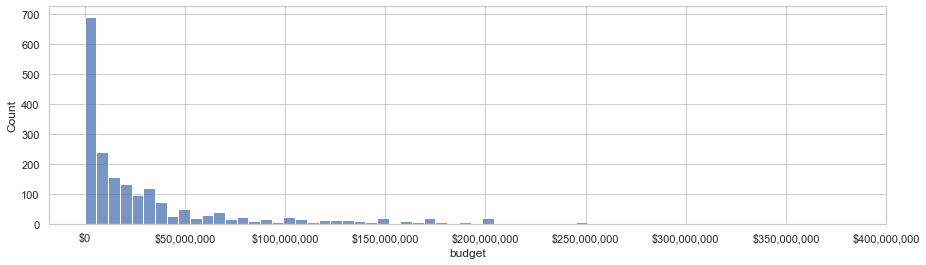

In [95]:
#Examine distribution of budgets using histogram
plt.figure(figsize=(15,4))
sns.set_style('whitegrid')
b=sns.histplot(data=prof_df,x='budget')
ticks=b.get_xticks().tolist()
b.xaxis.set_ticks(ticks[1:])
xlabels=['$'+'{:,.0f}'.format(x) for x in ticks[1:]]
b.set_xticklabels(xlabels)

Budgets are right skewed with the mode less than $10 million. Large studios under companies like Microsoft tend to make larger budget films, so there appears to be a large number of smaller budget independent films in the dataset.

In [99]:
#Make a profit column (ww_gross - budget)
prof_df['profit']=prof_df['ww_gross']-prof_df['budget']
print(prof_df['profit'].describe())

count    1.945000e+03
mean     7.451016e+07
std      1.837612e+08
min     -1.973674e+08
25%     -2.078248e+06
50%      4.042068e+06
75%      6.959414e+07
max      2.441501e+09
Name: profit, dtype: float64


(-250000000.0, 1500000000.0)

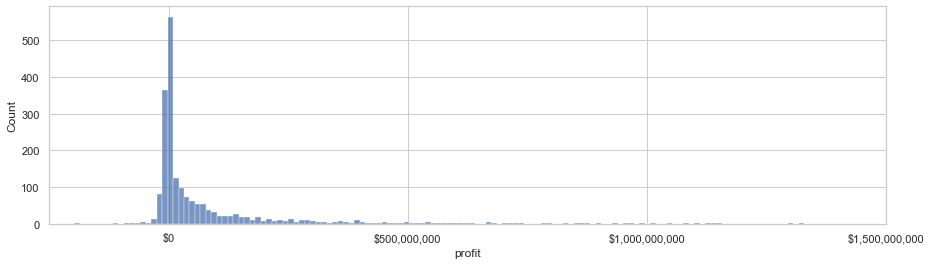

In [104]:
#Show distribution of profit with histogram
plt.figure(figsize=(15,4))
sns.set_style('whitegrid')
b=sns.histplot(data=prof_df,x='profit')
ticks=b.get_xticks().tolist()
b.xaxis.set_ticks(ticks[1:-3])
xlabels=['$'+'{:,.0f}'.format(x) for x in ticks[1:-3]]
b.set_xticklabels(xlabels)
b.set_xlim(-250000000,1500000000)

Profit is also right skewed with the majority of movies falling below 250 million USD. There are a few outliers above 1.5 billion USD but the axis was limited to see the majority of movies more clearly.

## Profit vs. Budget ##
Examine if there is a correlation between a movie's budget and its overall profit. Examine for low and high budget films.

[Text(0.0, 0, '$0'),
 Text(50000000.0, 0, '$50,000,000'),
 Text(100000000.0, 0, '$100,000,000'),
 Text(150000000.0, 0, '$150,000,000'),
 Text(200000000.0, 0, '$200,000,000'),
 Text(250000000.0, 0, '$250,000,000'),
 Text(300000000.0, 0, '$300,000,000'),
 Text(350000000.0, 0, '$350,000,000'),
 Text(400000000.0, 0, '$400,000,000')]

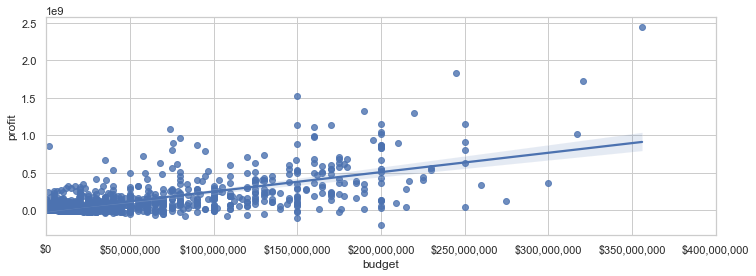

In [108]:
plt.figure(figsize=(12,4))
pb=sns.regplot(data=prof_df,x='budget',y='profit')
ticks=pb.get_xticks().tolist()
pb.xaxis.set_ticks(ticks)
xlabels=['$'+'{:,.0f}'.format(x) for x in ticks]
pb.set_xticklabels(xlabels)

Profit and budget are positively correlated, although it is clear that not all high budget films make a large profit. Since Microsoft is a large company that will have the capital to invest in high budget films that will have a better chance of making a large profit, we will make a column in prof_df that identifies 'high-budget' films so that these can be analyzed separately.

In [111]:
#Examine what to call high budget
prof_df['budget'].describe()

count          1,945.00
mean      33,378,318.68
std       49,766,651.08
min                0.00
25%        3,000,000.00
50%       13,000,000.00
75%       40,000,000.00
max      356,000,000.00
Name: budget, dtype: float64

If all films with budgets over 40 million are marked 'high-budget' this will include the most expensive 1/4 of movies.  We will use this as the threshold.

In [112]:
#create column to identify high budget films, budgets greater than 40,000,000
#top 1/4 of all budgets 

prof_df['high_budg']=prof_df['budget'].apply(lambda x: 
                                             True if x>40000000 else False)
prof_df['high_budg'].sum()

438

<Figure size 576x288 with 0 Axes>

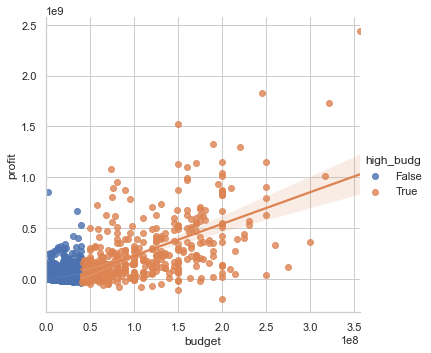

In [114]:
#show relplot of budget and profit with distinction of high vs low budget
plt.figure(figsize=(8,4))
sns.lmplot(data=prof_df,x='budget',y='profit',hue='high_budg')

In [169]:
#Separate high and low budget films
high_df=prof_df.query("high_budg==True")
low_df=prof_df.query("high_budg==False")

Text(0.5, 1.0, 'Low Budget Films')

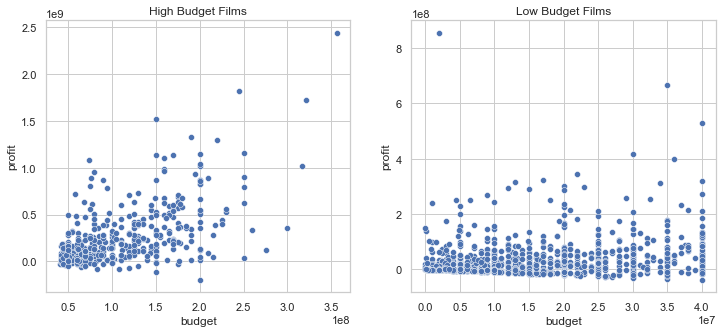

In [307]:
#Plot low budget and high budget separately to see in more detail
fig, ax = plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(data=high_df,x='budget',y='profit',ax=ax[0])
ax[0].set_title('High Budget Films')
sns.scatterplot(data=low_df,x='budget',y='profit',ax=ax[1])
ax[1].set_title('Low Budget Films')



In [125]:
#compute correlations between budget and profit
high_corr=high_df['budget'].corr(high_df['profit'])
low_corr=low_df['budget'].corr(low_df['profit'])
print('high budget/profit correlation:v '+str(high_corr))
print('low budget/profit correlation: '+str(low_corr))

high budget/profit correlation:v 0.5766409472402435
low budget/profit correlation: 0.3181716986049638


In [126]:
import statsmodels.api as sm

In [127]:
#high budget linear regression
x=high_df['budget'].to_list()
x=sm.add_constant(x)
y=high_df['profit'].to_list()
results=sm.OLS(y,x).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     217.2
Date:                Fri, 08 Oct 2021   Prob (F-statistic):           3.53e-40
Time:                        20:20:05   Log-Likelihood:                -9095.7
No. Observations:                 438   AIC:                         1.820e+04
Df Residuals:                     436   BIC:                         1.820e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.333e+07   2.59e+07     -3.212      0.0

In [131]:
#low budget linear regression
x=low_df['budget'].to_list()
x=sm.add_constant(x)
y=low_df['profit'].to_list()
results=sm.OLS(y,x).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     169.5
Date:                Fri, 08 Oct 2021   Prob (F-statistic):           8.46e-37
Time:                        20:29:10   Log-Likelihood:                -29041.
No. Observations:                1507   AIC:                         5.809e+04
Df Residuals:                    1505   BIC:                         5.810e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.266e+06   2.05e+06      1.589      0.1

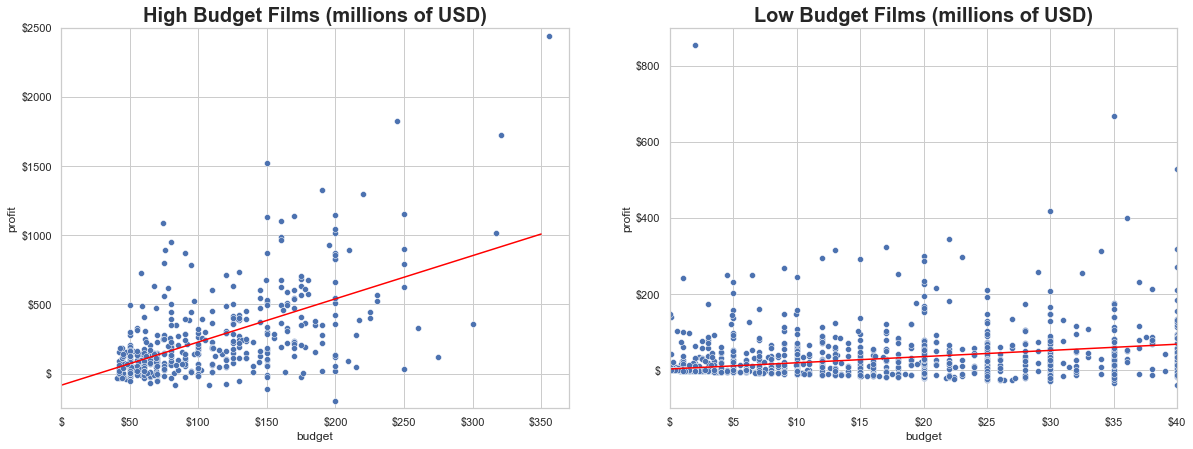

In [308]:
#plot scatterplots with correlation line
fig, ax = plt.subplots(1,2,figsize=(20,7))
sns.scatterplot(data=high_df,x='budget',y='profit',ax=ax[0])
#create points for correlation line
x=[0,350000000]
y=[-83330000,((350000000)*3.1208-83330000)]
sns.lineplot(x=x,y=y,ax=ax[0],color='red')

#format x axis into millions of dolalrs
ticks=ax[0].get_xticks().tolist()
ax[0].xaxis.set_ticks(ticks)
xlabels=['$'+'{:.0f}'.format(x)[:-6] for x in ticks]
ax[0].set_xticklabels(xlabels)
ax[0].set_xlim(0,370000000)

#format numbers on y axis into millions of dollars
ticks=ax[0].get_yticks().tolist()
ax[0].yaxis.set_ticks(ticks[1:])
ylabels=['$'+'{:.0f}'.format(y)[:-6] for y in ticks[1:]]
ax[0].set_yticklabels(ylabels)
ax[0].set_ylim(-250000000,2500000000)
ax[0].set_title('High Budget Films (millions of USD)',fontsize=20,
               fontweight='bold')


sns.scatterplot(data=low_df,x='budget',y='profit',ax=ax[1])
x1=[0,40000000]
y1=[3266000,(40000000*1.6255)+3266000]
sns.lineplot(x=x1,y=y1,ax=ax[1],color='red')
ax[1].set_title('Low Budget Films (millions of USD)',fontsize=20,
               fontweight='bold')

#format x axis into millions of dolalrs
ticks=ax[1].get_xticks().tolist()
ax[1].xaxis.set_ticks(ticks)
xlabels=['$'+'{:.0f}'.format(x)[:-6] for x in ticks]
ax[1].set_xticklabels(xlabels)
ax[1].set_xlim(0,40000000)

#format numbers on y axis into millions of dollars
ticks=ax[1].get_yticks().tolist()
ax[1].yaxis.set_ticks(ticks[1:])
ylabels=['$'+'{:.0f}'.format(y)[:-6] for y in ticks[1:]]
ax[1].set_yticklabels(ylabels)
ax[1].set_ylim(-100000000,900000000)

plt.savefig('images/high_low_profit.png')

High budget films (over $40 million) are more positively correlated with higher profits than movies with low budgets (coefficient of 3.12 vs. 1.62). The R-Squared value of this correlation is ~.33, which means it is not an incredibly strong fit. While there is a greater opportunity to make higher profit with a higher budget, it is not guaranteed.  We'll examine which genres tend to make higher profits so that we can refine our recommendations to Microsoft.

## Profit vs. Genre ##

Examine which genres tend to make the most profit among high budget films.

In [170]:
high=high_df.copy()
high['genres']=high['genres'].str.strip('[]').str.split(',')
high['genres']=high['genres'].apply(lambda x: [s.strip() for s in x])

In [197]:
high['genres']=high['genres'].apply(lambda x: [s.strip("''") for s in x])
high_exp=high.explode('genres')
high_exp.head()

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month,profit,high_budg
0,tt0249516,Foodfight!,2012,91.00,Action,"65,000,000.00","120,141.00",PG,2.00,"-64,879,859.00",True
0,tt0249516,Foodfight!,2012,91.00,Animation,"65,000,000.00","120,141.00",PG,2.00,"-64,879,859.00",True
0,tt0249516,Foodfight!,2012,91.00,Comedy,"65,000,000.00","120,141.00",PG,2.00,"-64,879,859.00",True
3,tt0359950,The Secret Life of Walter Mitty,2013,114.00,Adventure,"90,000,000.00","188,133,322.00",PG,12.00,"98,133,322.00",True
3,tt0359950,The Secret Life of Walter Mitty,2013,114.00,Comedy,"90,000,000.00","188,133,322.00",PG,12.00,"98,133,322.00",True


In [199]:
high_exp['genres'].value_counts()

Adventure    251
Action       247
Comedy       167
Drama        101
Animation     84
Fantasy       77
Sci-Fi        73
Thriller      52
Crime         51
Family        37
Mystery       22
Romance       21
Biography     18
Horror        15
History        9
Western        4
Sport          4
Musical        4
War            3
Music          3
Name: genres, dtype: int64

In [200]:
#groupby genres and calculate mean profit, then sort to get descending order
g_mean_prof=high_exp.groupby('genres'
                        ).mean()['profit'].sort_values(ascending=False)
g_mean_order=g_mean_prof.index

Text(0.5, 1.0, 'High Budget Film Mean Profit by Genre (millions of USD)')

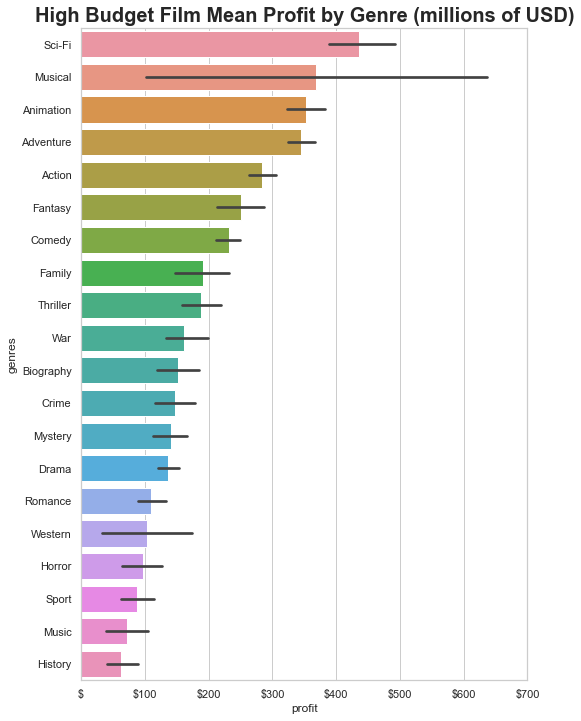

In [201]:
#plot the mean profit for each genre
plt.figure(figsize=(8,12))
gm=sns.barplot(data=high_exp,x='profit',y='genres',ci=68,order=g_mean_order)
#format x axis into millions of dolalrs
ticks=gm.get_xticks().tolist()
gm.xaxis.set_ticks(ticks)
xlabels=['$'+'{:.0f}'.format(x)[:-6] for x in ticks]
gm.set_xticklabels(xlabels)
gm.set_xlim(0,700000000)
gm.set_title('High Budget Film Mean Profit by Genre (millions of USD)',fontsize=20,
            fontweight='bold')

In [202]:
#groupby genres and calculate mean profit, then sort to get descending order
g_med_prof=high_exp.groupby('genres'
                        ).median()['profit'].sort_values(ascending=False)
g_med_order=g_med_prof.index

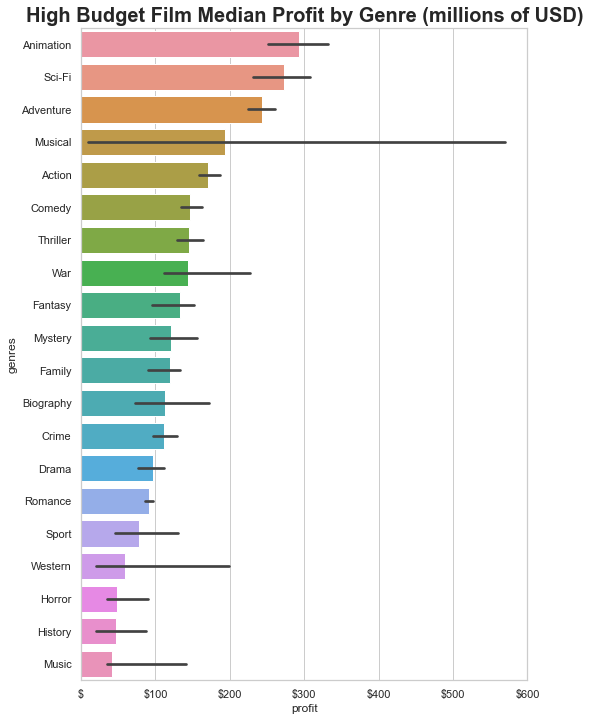

In [310]:
#plot the mean profit for each genre
plt.figure(figsize=(8,12))
gm=sns.barplot(data=high_exp,x='profit',y='genres',ci=68,estimator=np.median,
               order=g_med_order)
#format x axis into millions of dolalrs
ticks=gm.get_xticks().tolist()
gm.xaxis.set_ticks(ticks)
xlabels=['$'+'{:.0f}'.format(x)[:-6] for x in ticks]
gm.set_xticklabels(xlabels)
#gm.set_xlim(0,700000000)
gm.set_title('High Budget Film Median Profit by Genre (millions of USD)',fontsize=20,
            fontweight='bold')

plt.savefig('images/high_med_prof_genre.png')

The same five genres have both the five highest means and medians. Movies that can be classified as Animation, Sci-Fi, Adventure, Action, and Musical tend to have the highest profit.  Of note, the confidence interval for Musicals is very large, so that may be a riskier recommendation.  We'll examine the distributions of these five genres in more detail and look at which ratings and release months tend to work best with each genre.

In [204]:
q="(genres=='Animation') | (genres=='Action') | (genres=='Sci-Fi') | \
(genres=='Musical') | (genres=='Adventure')"
h=high_exp.copy()
top_5=h.query(q)
top_5.head()

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month,profit,high_budg
0,tt0249516,Foodfight!,2012,91.00,Action,"65,000,000.00","120,141.00",PG,2.00,"-64,879,859.00",True
0,tt0249516,Foodfight!,2012,91.00,Animation,"65,000,000.00","120,141.00",PG,2.00,"-64,879,859.00",True
3,tt0359950,The Secret Life of Walter Mitty,2013,114.00,Adventure,"90,000,000.00","188,133,322.00",PG,12.00,"98,133,322.00",True
5,tt0369610,Jurassic World,2015,124.00,Action,"150,000,000.00","1,670,516,444.00",PG-13,6.00,"1,520,516,444.00",True
5,tt0369610,Jurassic World,2015,124.00,Adventure,"150,000,000.00","1,670,516,444.00",PG-13,6.00,"1,520,516,444.00",True


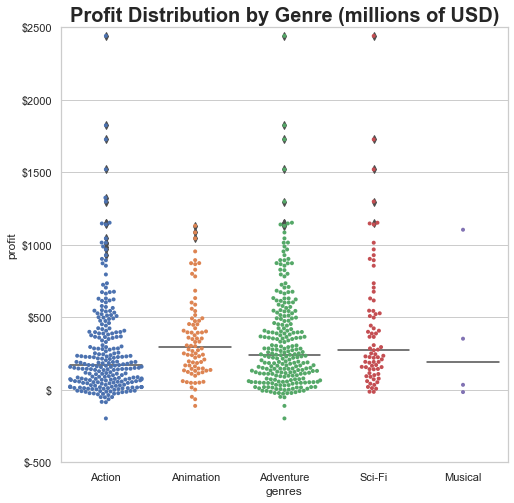

In [312]:
#plot profit distributions of top 5 genres
plt.figure(figsize=(8,8))
p=sns.swarmplot(data=top_5,x='genres',y='profit',size=4)
sns.boxplot(data=top_5,x='genres',y='profit',showbox=False,
      showcaps=False,whiskerprops={'visible':False})

#format numbers on y axis into millions of dollars
ticks=p.get_yticks().tolist()
p.yaxis.set_ticks(ticks)
ylabels=['$'+'{:.0f}'.format(y)[:-6] for y in ticks]
p.set_yticklabels(ylabels)
p.set_ylim(-500000000,2500000000)
p.set_title('Profit Distribution by Genre (millions of USD)',fontsize=20,
           fontweight='bold')

plt.savefig('images/prof_dist_genre.png')

This plot shows that Action and Animation have the largest number of observations. All genres but Musical have right skews, with the majority of films under $500 million profit and a many that have profit close to zero.  This does not mean that they are not good choices for genre, it just reflects the risk in making any film. Profit is more likely with these genres, but not guaranteed.  We can also see the outliers that make the mean so much higher than the medians.  The genre Musical only has 4 observations, which are not enough to make a solid recommendation to Microsoft. We will not include this genre in the analysis of rating and release month.

## Profit vs. Genre/Rating ##

Examine which MPAA ratings within the top 4 genres tend to have the highest profit.

Text(0.5, 1.0, 'Profit Distribution by Rating (millions of USD)')

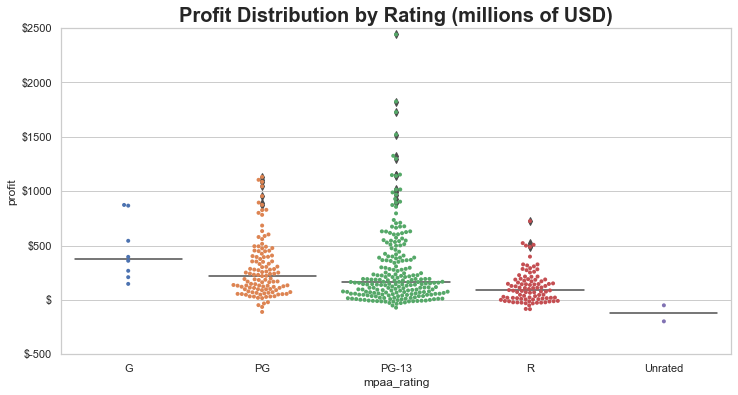

In [281]:
#First examine distribution of profit across ratings including all genres
plt.figure(figsize=(12,6))
r=sns.boxplot(data=high_df,x='mpaa_rating',y='profit',showbox=False,
      showcaps=False,whiskerprops={'visible':False},
             order=['G','PG','PG-13','R','Unrated'])
sns.swarmplot(data=high_df,x='mpaa_rating',y='profit',
              order=['G','PG','PG-13','R','Unrated'],size=4)

#format numbers on y axis into millions of dollars
ticks=r.get_yticks().tolist()
r.yaxis.set_ticks(ticks)
ylabels=['$'+'{:.0f}'.format(y)[:-6] for y in ticks]
r.set_yticklabels(ylabels)
r.set_ylim(-500000000,2500000000)
r.set_title('Profit Distribution by Rating (millions of USD)',fontsize=20,
           fontweight='bold')

G movies have the highest median, but the sample size for high budget movies is low. PG has the next highest followed by PG-13 and then R.  Since there are only two movies that are unrated, we'll remove them for the genre analysis to make the plots simpler.  

All of the top three ratings are right skewed distributions with PG-13 having the highest number of observations and the most high-profit outliers.

In [291]:
#filter top_5 to remove musicals
q1="(genres=='Animation') | (genres=='Action') | (genres=='Sci-Fi') | \
(genres=='Adventure')"
top_4=top_5.copy().query(q1)
top_4=top_4[top_4['genres']!='Unrated']
top_4.head()

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month,profit,high_budg
0,tt0249516,Foodfight!,2012,91.00,Action,"65,000,000.00","120,141.00",PG,2.00,"-64,879,859.00",True
0,tt0249516,Foodfight!,2012,91.00,Animation,"65,000,000.00","120,141.00",PG,2.00,"-64,879,859.00",True
3,tt0359950,The Secret Life of Walter Mitty,2013,114.00,Adventure,"90,000,000.00","188,133,322.00",PG,12.00,"98,133,322.00",True
5,tt0369610,Jurassic World,2015,124.00,Action,"150,000,000.00","1,670,516,444.00",PG-13,6.00,"1,520,516,444.00",True
5,tt0369610,Jurassic World,2015,124.00,Adventure,"150,000,000.00","1,670,516,444.00",PG-13,6.00,"1,520,516,444.00",True


<Figure size 432x864 with 0 Axes>

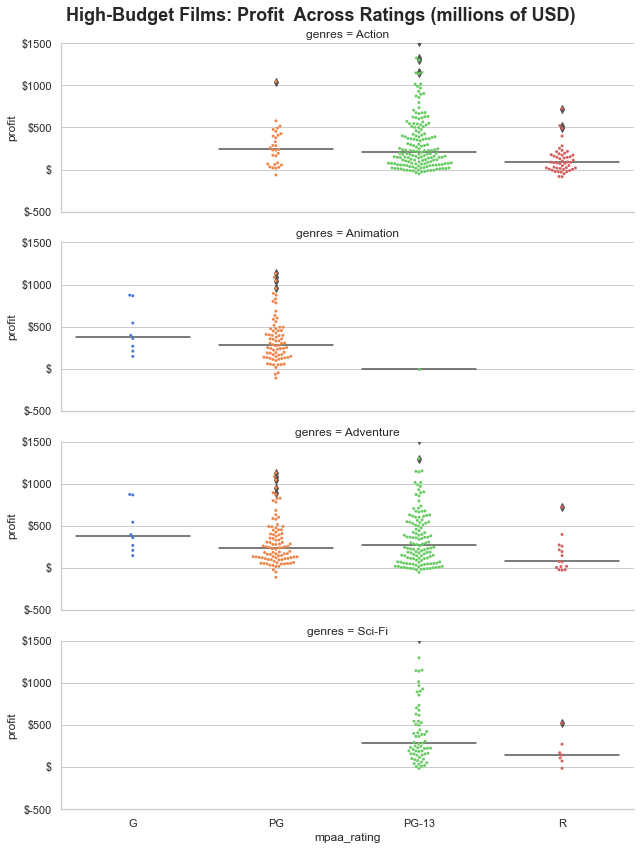

In [313]:
plt.figure(figsize=(6,12))

rg=sns.FacetGrid(top_4,row='genres',aspect=3)
rg.map(sns.boxplot, 'mpaa_rating','profit', 
       order=['G','PG','PG-13','R'],palette='muted',showbox=False,
      showcaps=False,whiskerprops={'visible':False})
rg.map(sns.swarmplot,'mpaa_rating','profit',
              order=['G','PG','PG-13','R'],size=3,palette='muted')

#fix y-axis to display millions of USD
for ax in rg.axes.flat:
    ticks=ax.get_yticks().tolist()
    ax.yaxis.set_ticks(ticks)
    ylabels=['$'+'{:.0f}'.format(y)[:-6] for y in ticks]
    ax.set_yticklabels(ylabels)
    ax.set_ylim(-500000000,1500000000)
    

rg.fig.suptitle('High-Budget Films: Profit  Across Ratings (millions of USD)',
                fontsize=18,fontweight='bold',va='top',ha='center')
plt.tight_layout()

plt.savefig('images/prof_genre_ratings.png')

Action: The majority of Action movies have a PG-13 rating. The median for PG Action movies is slightly higher, but the sample is smaller. Both PG and PG-13 tend to have higher profit than R. Best recommendation would be to make a PG-13 Action movie.

Animation: Almost all of these movies are rated PG. G Animation films can still perform well and have a slightly higher mean, but PG is the best recommendation for this genre.

Adventure: PG and PG-13 films perform well, but PG-13 has a slightly higher median and more high-profit outliers. G has too few observations to make a solid recommendation. PG-13 is the recommended rating level for Adventure.

Sci-Fi: All movies in this genre are either PG-13 or R. PG-13 has a higher median and more observations. The best recommendation for Sci-Fi is PG-13.

## Profit vs. Genre/Release Month ##

Examine which release months have led to the highest profits for the top 4 genres.

In [288]:
high_df.head()

,tconst,original_title,start_year,runtime_minutes,genres,budget,ww_gross,mpaa_rating,month,profit,high_budg
0,tt0249516,Foodfight!,2012,91.00,"['Action', 'Animation', 'Comedy']","65,000,000.00","120,141.00",PG,2.00,"-64,879,859.00",True
3,tt0359950,The Secret Life of Walter Mitty,2013,114.00,"['Adventure', 'Comedy', 'Drama']","90,000,000.00","188,133,322.00",PG,12.00,"98,133,322.00",True
5,tt0369610,Jurassic World,2015,124.00,"['Action', 'Adventure', 'Sci-Fi']","150,000,000.00","1,670,516,444.00",PG-13,6.00,"1,520,516,444.00",True
7,tt0376136,The Rum Diary,2011,119.00,"['Comedy', 'Drama']","45,000,000.00","30,134,958.00",R,10.00,"-14,865,042.00",True
9,tt0398286,Tangled,2010,100.00,"['Adventure', 'Animation', 'Comedy']","260,000,000.00","592,462,816.00",PG,11.00,"332,462,816.00",True


In [292]:
#turn release months into strings
high['month']=high['month'].apply(lambda x: str(int(x)))
top_4['month']=top_4['month'].apply(lambda x: str(int(x)))
m_order=[str(x) for x in list(range(1,13))]

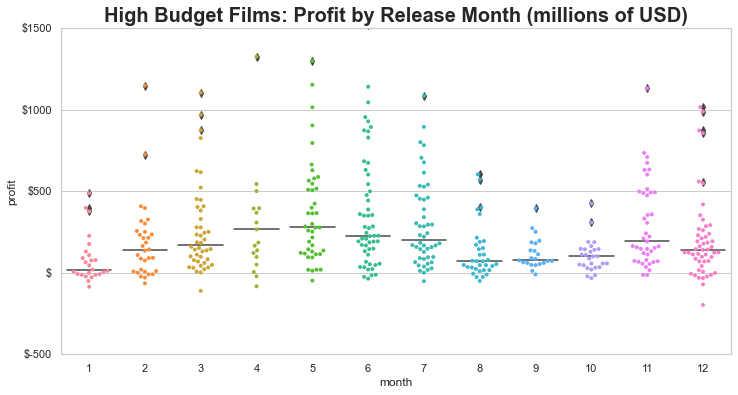

In [314]:
#First examine distribution of profit across ratings including all genres
plt.figure(figsize=(12,6))
r=sns.boxplot(data=high,x='month',y='profit',showbox=False,
      showcaps=False,whiskerprops={'visible':False},
             order=m_order)
sns.swarmplot(data=high,x='month',y='profit',
              order=m_order,size=4)

#format numbers on y axis into millions of dollars
ticks=r.get_yticks().tolist()
r.yaxis.set_ticks(ticks)
ylabels=['$'+'{:.0f}'.format(y)[:-6] for y in ticks]
r.set_yticklabels(ylabels)
r.set_ylim(-500000000,1500000000)
r.set_title('High Budget Films: Profit by Release Month (millions of USD)',fontsize=20,
           fontweight='bold')

plt.savefig('images/prof_month.png')

Median profit peaks in late Spring/Early Summer and in November.  The lowest months are January and August.

May has the highest median profit followed by April, when relatively fewer high-budget movies have been released, and then June and July when a higher number of high-budget movies are released. November's median is similar to July's.

<Figure size 432x1080 with 0 Axes>

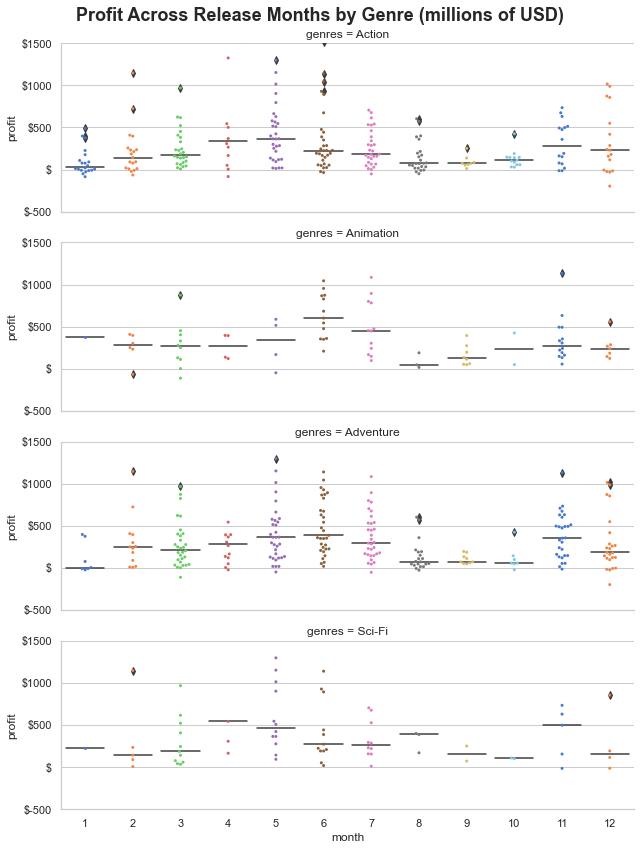

In [305]:
#Plot profit by release month across the top 4 genres

plt.figure(figsize=(6,15))

rg=sns.FacetGrid(top_4,row='genres',aspect=3)
rg.map(sns.boxplot, 'month','profit',palette='muted',showbox=False,
      showcaps=False,order=m_order,whiskerprops={'visible':False})
rg.map(sns.swarmplot,'month','profit',size=3,palette='muted',
      order=m_order)

#fix y-axis to display millions of USD
for ax in rg.axes.flat:
    ticks=ax.get_yticks().tolist()
    ax.yaxis.set_ticks(ticks)
    ylabels=['$'+'{:.0f}'.format(y)[:-6] for y in ticks]
    ax.set_yticklabels(ylabels)
    ax.set_ylim(-500000000,1500000000)
    

rg.fig.suptitle('Profit Across Release Months by Genre (millions of USD)',
                fontsize=18,fontweight='bold',va='top',ha='center')
plt.tight_layout()

Broken down by genre, profit still peaks at similar months to the overall grouping of high budget films in May/June and November.

Animation peaks more in June and not as much in November, so summer releases are a better recommendation for that genre.

Sci-Fi peaks highest in April (few observations) and then in November, although it till has a high median in May.

Adventure also does almost as well in November as it does in May/June.

Action is highest in May and higher in April than June/July. It has a moderate increase in profit in November as well.

## Profit vs. Genre/Rating/Month ##

Examine which groupings of genre, rating, and month have the highest median profit.

In [295]:
#groupby genres, mpaa rating, and month and calculate median profit 
#and count movies in category
all_3_med=high_exp.groupby(['genres','mpaa_rating',
                    'month']).agg({'profit': ['count',
                    'median']}).sort_values(('profit','median'),ascending=False)
all_3_med.head(20)

profit                  
                             count            median
genres    mpaa_rating month                         
Musical   PG          3.00       1  1,104,434,525.00
Fantasy   PG-13       12.00      4  1,002,092,358.00
Thriller  PG-13       4.00       2    913,239,537.00
Action    PG          6.00       2    760,588,523.00
Adventure R           2.00       1    724,836,791.00
Animation PG          6.00       8    642,884,646.50
Adventure PG          6.00       8    642,884,646.50
Sci-Fi    PG-13       4.00       5    544,421,503.00
Comedy    G           6.00       5    543,559,645.00
Adventure G           6.00       5    543,559,645.00
Animation G           6.00       5    543,559,645.00
Sci-Fi    R           3.00       1    522,179,950.00
Adventure PG-13       11.00     11    512,796,076.00
Sci-Fi    PG-13       5.00      11    508,982,323.00
Mystery   R           5.00       1    506,764,305.00
Crime     PG-13       4.00       3    501,137,675.00
Sci-Fi    PG-13       11.00      5    498,344,137.00
Fantasy   PG-13       11.00      6    493,789,608.00
Drama     PG          11.00      1    489,016,565.00
Comedy    PG          6.00       8    477,952,240.50

One has to be careful when examining these results, since some of the groups only have 1 or 2 movies, which means the median says more about the success of an individual movie than a group of movies with the same characteristics.  We can see in the top 20 there are quite a few groups with June releases.  

In [299]:
g_dum=pd.get_dummies(high_exp['genres'],drop_first=True)
mp_dum=pd.get_dummies(high_exp['mpaa_rating'],drop_first=True)
m_dum=pd.get_dummies(high_exp['month'],drop_first=True)
x=pd.concat([g_dum,mp_dum,m_dum],axis=1)
x.head()

,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,...,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [300]:
x=sm.add_constant(x)
y=high_exp['profit']

In [301]:
results=sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     7.825
Date:                Sun, 10 Oct 2021   Prob (F-statistic):           1.65e-33
Time:                        19:46:38   Log-Likelihood:                -25962.
No. Observations:                1243   AIC:                         5.199e+04
Df Residuals:                    1208   BIC:                         5.217e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.524e+08   7.48e+07      3.373      0.001    1.06e+08    3.99e+08
Adventure   2.383e+07   2.69e+07      0.886      0.376   -2.89e+07    7.66e+07
Animation   2.066e+07   4.19e+07      0.493      0.622   -6.15e+07    1.03e+08
Biography  -4.495e+07   7.21e+07     -0.624      0.533   -1.86e+08    9.64e+07
Comedy     -7.563e+07   3.07e+07     -2.465      0.014   -1.36e+08   -1.54e+07
Crime      -8.726e+07   4.56e+07     -1.914      0.056   -1.77e+08    2.19e+06
Drama      -8.739e+07   3.49e+07     -2.502      0.012   -1.56e+08   -1.89e+07
Family     -1.104e+08   5.45e+07     -2.024      0.043   -2.17e+08    -3.4e+06
Fantasy     -3.37e+07   3.79e+07     -0.888      0.375   -1.08e+08    4.07e+07
History    -1.335e+08   9.94e+07     -1.344      0.179   -3.28e+08    6.14e+07
Horror     -9.733e+07   7.77e+07     -1.253      0.210    -2.5e+08     5.5e+07
Music      -2.054e+08   1.69e+08     -1.218      0.223   -5.36e+08    1.25e+08
Musical     2.979e+07   1.46e+08      0.204      0.839   -2.57e+08    3.17e+08
Mystery    -8.937e+07   6.52e+07     -1.370      0.171   -2.17e+08    3.86e+07
Romance    -1.573e+08   6.63e+07     -2.372      0.018   -2.87e+08   -2.72e+07
Sci-Fi      1.109e+08   3.89e+07      2.850      0.004    3.45e+07    1.87e+08
Sport      -1.684e+08   1.47e+08     -1.149      0.251   -4.56e+08    1.19e+08
Thriller   -5.135e+07   4.46e+07     -1.151      0.250   -1.39e+08    3.62e+07
War        -3.884e+07   1.69e+08     -0.230      0.818    -3.7e+08    2.93e+08
Western    -1.263e+08   1.47e+08     -0.861      0.390   -4.14e+08    1.62e+08
PG         -6.141e+07   6.33e+07     -0.970      0.332   -1.86e+08    6.29e+07
PG-13      -7.467e+07   6.41e+07     -1.165      0.244      -2e+08    5.11e+07
R          -1.745e+08   6.67e+07     -2.617      0.009   -3.05e+08   -4.37e+07
Unrated    -4.052e+08   1.36e+08     -2.981      0.003   -6.72e+08   -1.39e+08
2.0         6.729e+07   4.67e+07      1.440      0.150   -2.44e+07    1.59e+08
3.0         1.106e+08   4.41e+07      2.508      0.012    2.41e+07    1.97e+08
4.0         3.239e+08    5.3e+07      6.109      0.000     2.2e+08    4.28e+08
5.0         2.169e+08   4.42e+07      4.905      0.000     1.3e+08    3.04e+08
6.0         2.236e+08   4.34e+07      5.157      0.000    1.39e+08    3.09e+08
7.0         1.421e+08   4.38e+07      3.241      0.001    5.61e+07    2.28e+08
8.0         1.392e+07   4.63e+07      0.301      0.764   -7.69e+07    1.05e+08
9.0        -4.512e+06    5.1e+07     -0.089      0.929   -1.04e+08    9.55e+07
10.0        2.058e+07   4.81e+07      0.428      0.669   -7.37e+07    1.15e+08
11.0        1.504e+08   4.53e+07      3.322      0.001    6.16e+07    2.39e+08
12.0        1.348e+08   4.32e+07      3.119      0.002       5e+07     2.2e+08
==============================================================================
Om

The R squared for this model is only .18 - for the purposes of this analysis for Microsoft, we already have a good idea of what recommendations we will make. I won't explore performing multiple linear regression on this dataset any further.

# Evaluation

While this data was not a comprehensive list of all movies made in the US in the last 10 years, it did include most of the large studio movies that would be comparable to what Microsoft would make.  Many of the films that were filtered out due to missing data had smaller or unknown budgets and would not have been a part of the high budget group.  Therefore, I am reasonably confident that this dataset provided sound information about film performance for Microsoft's purposes.

It is important to note that this was a descriptive analysis based on correlation of certain characteristics with profit. It did not establish clear causation between those characteristics and increased profit. Many films with the recommended characteristics still perform poorly and the quality of the film produced is still important. However, making high-budget films in these categories can give the studio a better chance at success.

There are also other characteristics that can predict performance that are not included in this analysis. Combinations of genres could be examined as well as leading actors, director, script content, and type of storyline.

# Conclusions

This analysis led to four recommendations for determining what type of films to produce.

1) High budget films (defined as over $40 million in this project) are more positively correlated with profit than low budget films. Since Microsoft is a large company with ample capital, they should invest in higher budget productions.

2) Among high budget films, those which can be classified as Animation, Action, Adventure, or Sci-Fi have higher profits on average. Microsoft should consider making films that fall into one or more of these genres.

3) High-performing MPAA Ratings vary by genre, although overall R-Rated movies tend to have lower profits. Below is a breakdown of recommended MPAA rating for the top four genres:<br>
>-Animation: PG<br>
>-Action: PG-13<br>
>-Adventure: PG-13<br>
>-Sci-Fi: PG-13
    
4) For high-budget films, profits tend to be higher in late Spring and early Summer (April-July) and in the holiday months (November and December). The month with the highest median profit is May, although this varies slightly by genre. Release dates in either of these peak seasons could give a high-budget film a better chance for success.


### Next Steps ###

More advanced methods could be utilized to create a predictive model for profit. Work has been done on machine learning models that can predict box office income based on characteristics of the film. There are also models that can predict outcomes from a script by using natural language processing to evaluate the storyline, genre, and type of language used. This could allow Microsoft to narrow down profitable films to produce within the overarching categories recommended by this project.